# Predicting the Genre and Highest Charting Position of Spotify Top Songs
Nina Ahmed, Benjamin Beal, Conrad Li, Siddhi Patadia

In [44]:
# Imports
import csv
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer

# Intro
The relationship between the musical characteristics of each song and the popularity of each song is important for music production and song artists companies to create the next bit song hits. This Spotify dataset contains songs that were on the Top 200 Weekly Global charts for Spotify in 2020 & 2021 along with each song’s genre, song artist ID, and various musical attributes. There are 21 features and 1556 records. The highest charting position of each song is a number that indicates the highest position the song ever ranked. In this project, we will attempt to predict song genre based on both song metadata as well as musical features generated by Spotify in-house algorithms. We will also try to predict the highest charting position of each song. Our classification algorithm can be used by musical production companies and song artists to gauge how certain metrics relate to genre, how genre can be predicted based on these features, and how these features relate to the ability of the song to make the top charts.

# Data Prep

This dataset contains songs that were on the Top 200 Weekly Global charts for Spotify in 2020 & 2021. For each song, we have the following raw features.

| Feature                   | Feature Type |
|---------------------------|--------------|
| Index                     | Numeric      |
| Highest Charting Position | Numeric      |
| Number of Times Charted   | Numeric      |
| Week of Highest Charting  | Categorical  |
| Song Name                 | Categorical  |
| Song ID                   | Categorical  |
| Artist                    | Categorical  |
| Artist Followers          | Numeric      |
| Streams                   | Numeric      |
| Genre                     | Categorical  |
| Release Date              | Numeric      |
| Weeks Charted             | Numeric      |
| Popularity                | Numeric      |
| Danceability              | Numeric      |
| Acousticness              | Numeric      |
| Energy                    | Numeric      |
| Loudness                  | Numeric      |
| Speechiness               | Numeric      |
| Liveness                  | Numeric      |
| Tempo                     | Numeric      |
| Duration (ms)             | Numeric      |
| Valence                   | Numeric      |
| Chord                     | Categorical  |

 Genre will be a feature when predicting charting position and vice versa.

In [74]:
# Entire Dataset
path = 'spotify_dataset.csv'
data = pd.DataFrame(pd.read_csv(path))
data.head()

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,1,8,2021-07-23--2021-07-30,Beggin',"48,633,449",Måneskin,3377762,3Wrjm47oTz2sjIgck11l5e,"['indie rock italiano', 'italian pop']",...,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),"47,248,719",The Kid LAROI,2230022,5HCyWlXZPP0y6Gqq8TgA20,['australian hip hop'],...,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,3,1,11,2021-06-25--2021-07-02,good 4 u,"40,162,559",Olivia Rodrigo,6266514,4ZtFanR9U6ndgddUvNcjcG,['pop'],...,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,4,3,5,2021-07-02--2021-07-09,Bad Habits,"37,799,456",Ed Sheeran,83293380,6PQ88X9TkUIAUIZJHW2upE,"['pop', 'uk pop']",...,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,5,1,2021-07-23--2021-07-30,INDUSTRY BABY (feat. Jack Harlow),"33,948,454",Lil Nas X,5473565,27NovPIUIRrOZoCHxABJwK,"['lgbtq+ hip hop', 'pop rap']",...,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb


## Cleaning the dataset

### Removing irrelevant columns and missing values
For our analysis, we will exclude the index, song name, and song ID from our feature set. These features do not give any information that would be pertinent to classifying the genre or charting position of each song. We will also drop any records that do not have any classified song genres, chords, or duration recorded as these are considered incomplete records. We chose to drop these records as opposed to replacing values with the mean for that feature because each song varies significatly in terms of its features and there is no "true average" for each feature.

In [46]:
# Drop columns corresponding to: index, song name, song id
columns_to_exclude = [0, 4, 8]
data.drop(columns=data.columns[columns_to_exclude], inplace=True)

# some songs have no defined Chord
print('Songs with no defined Chord', np.sum([data['Chord'] == ' ']))
# some song have not defined genre
print("Song with no defined genre", np.sum([data['Genre'] == '[]']))
# some songs have no defined duration
print('Songs with no defined Duration', np.sum([data["Duration (ms)"] == ' ']))

# Drop rows with missing values
data['Chord'].replace(' ', np.nan, inplace=True)
data['Genre'].replace('[]', np.nan, inplace=True)
data['Duration (ms)'].replace(' ', np.nan, inplace=True)
data.dropna(inplace=True)

Songs with no defined Chord 11
Song with no defined genre 75
Songs with no defined Duration 11


### Fixing Data Types

This was done to make the calculations and comparisons during exploration easier since each feature would have the data type that best fits the range of values it can take on.


In [47]:
# fixing dtypes of values, so that they're floats
data['Streams'] = [int(stream.replace(',', '')) for stream in data['Streams'].tolist()]
types = {'Artist Followers':'int64', 'Duration (ms)':'int64', 'Popularity':'float','Danceability':'float', 'Acousticness':'float', 'Energy':'float', 'Liveness':'float','Loudness':'float', 'Speechiness':'float', 'Tempo':'float', 'Valence':'float'}
data = data.astype(types)

### Mapping Categorical Features to Classes

We mapped the artist feature to a new feature "Artist Class". This avoids dealing with string names in classification and instead, each artist corresponds to a unique identifier for that artist. The chord feature and genre feature were also engineered into new classes "Chord Class" and "Genre Class" for the same reason.

In [48]:
# Converting each artist to a class
artists = data['Artist'].tolist()
artists_set = set()
for artist in artists:
    multiple_artists = artist.split(", ")
    for each_artist in multiple_artists:
        artists_set.add(each_artist)

classes = range(len(artists_set))
artists_to_class = dict(zip(artists_set, classes))

# Adding classes as a column
artist_column = [[artists_to_class.get(each_artist) for each_artist in artist.split(", ")] for artist in artists]
data.insert(5, 'Artist_Class', artist_column)

In [49]:
# Converting each chord to a class
chords = set(data['Chord'].tolist())

classes = range(len(chords))
chords_to_class = dict(zip(chords, classes))

# Adding classes as a column
chord_column = [chords_to_class.get(chord_name) for chord_name in data['Chord'].tolist()]
data['Chord_Class'] = chord_column

Due to sheer amount of song genres (i.e. 393) in the dataset, we decided to aggregate the song genres into seven super genres

1. Pop
2. Rock
3. Rap
4. Hiphop
5. Country
6. Latin
7. Other

A song genre belongs to the pop, rock, rap, or hiphop super genre if it has that super genre in its name. For example, "australian hiphop" and "lgbtq+ hip hop" would both be classified as "hip hop".

Many songs also belong to multiple genres. In this case, we classify that song with the super genre that occurs most frequently in the dataset out of its associated list of super genres. For example, if a song belongs to "puerto rincan pop" and "trap latino," it would be classified as a "pop" record because "pop" is more prevalent in the dataset than "latin."

Some song genres have multiple super genres in their names (e.g. "pop rock"). To address this, we first established an ordering of super genres (i.e. "pop", "rock", "rap", "hiphop", "country", "latin", and "other"). We then associate each song genre name with the first super genre in the ordering that it contains. The "other" genre is positioned last so that it is only used if no other super genres match.

In [50]:
popular = ["pop", "rock", "rap", "hiphop", "country", "latin", "other"]
latin = ["mexican", "sertanejo", "forro", "piseiro", "latin", "espanol"]
genres = []

# Checks if a genre is a latin genre
def is_latin(genre):
    for latin_genre in latin:
        if latin_genre in genre:
            return True
    return False

genre_feat = data["Genre"].tolist()
for feat_list in genre_feat:
    # Parse genres
    temp = feat_list.replace("'", "")
    temp = temp.replace("[", "")
    temp = temp.replace("]", "")
    temp = temp.replace(" ", "")
    feats  = temp.split(",")
    song_genre = set()
    # Replace all pop, rock, rap, and hiphop genres with general genres
    for feat in feats:
        if "pop" in feat:
            song_genre.add("pop")
        elif "rock" in feat:
            song_genre.add("rock")
        elif "rap" in feat or "brooklyndrill" in feat:
            song_genre.add("rap")
        elif "hiphop" in feat:
            song_genre.add("hiphop")
        elif "country" in feat:
            song_genre.add("country")
        elif is_latin(feat):
            song_genre.add("latin")
    if (len(song_genre) == 0):
        song_genre.add("other")
    genres.append(song_genre)
        
# Find genre frequencies
genre_freq = Counter([genre for song_genres in genres for genre in song_genres])
# Replace song genres with the most common genre
for i in range(len(genres)):
    song_genres = list(genres[i])
    max_freq_genre = None
    max_freq = -1
    for j in range(len(song_genres)):
        if song_genres[j] in genre_freq:
            cur_freq = genre_freq.get(song_genres[j])
            if max_freq < cur_freq:
                max_freq = cur_freq
                max_freq_genre = song_genres[j]
    genres[i] = max_freq_genre

# Converting each genre to a class
unique_genres = set(genres)

classes = range(len(unique_genres))
genres_to_class = dict(zip(unique_genres, classes))

# Adding classes as a column
genre_column = [genres_to_class.get(genre_name) for genre_name in genres]
data['Genre_Class'] = genre_column


In [51]:
data.head()

,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Streams,Artist,Artist_Class,Artist Followers,Genre,Release Date,Weeks Charted,...,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord,Chord_Class,Genre_Class
0,1,8,2021-07-23--2021-07-30,48633449,Måneskin,[348],3377762,"['indie rock italiano', 'italian pop']",2017-12-08,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,...,-4.808,0.0504,0.1270,0.3590,134.002,211560,0.589,B,9,6
1,2,3,2021-07-23--2021-07-30,47248719,The Kid LAROI,[417],2230022,['australian hip hop'],2021-07-09,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,...,-5.484,0.0483,0.0383,0.1030,169.928,141806,0.478,C#/Db,10,3
2,1,11,2021-06-25--2021-07-02,40162559,Olivia Rodrigo,[358],6266514,['pop'],2021-05-21,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,...,-5.044,0.1540,0.3350,0.0849,166.928,178147,0.688,A,3,6
3,3,5,2021-07-02--2021-07-09,37799456,Ed Sheeran,[649],83293380,"['pop', 'uk pop']",2021-06-25,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,...,-3.712,0.0348,0.0469,0.3640,126.026,231041,0.591,B,9,6
4,5,1,2021-07-23--2021-07-30,33948454,Lil Nas X,[643],5473565,"['lgbtq+ hip hop', 'pop rap']",2021-07-23,2021-07-23--2021-07-30,...,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb,5,6


# Data Exploration

After some data preparation, we explored the features and plotted their ranges to visualize any outliers in the dataset.

### Noise and Outlier Detection

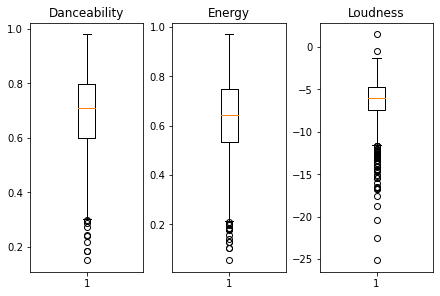

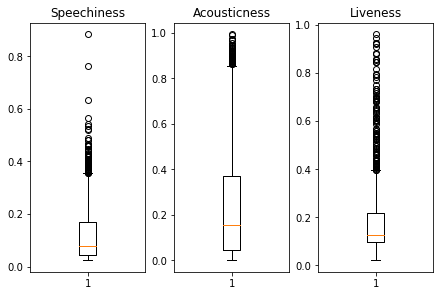

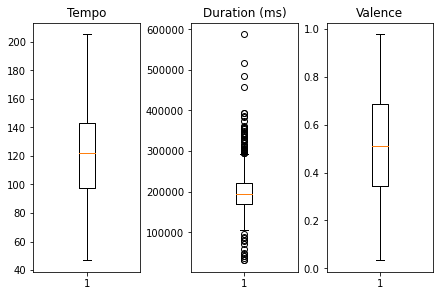

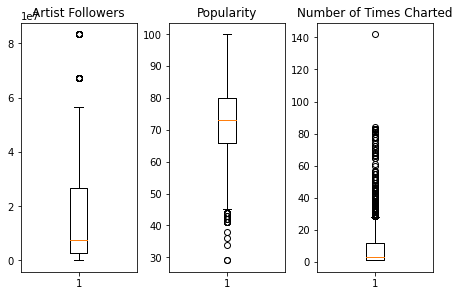

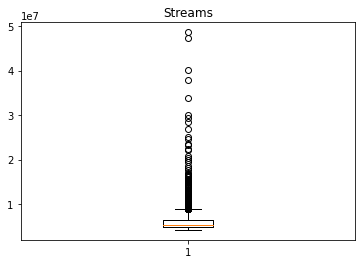

In [52]:
# Exploring and Checking for Noise and Outliers
musical_feat = ["Danceability", "Energy", "Loudness", "Speechiness", "Acousticness", "Liveness",  "Tempo", "Duration (ms)", "Valence", "Artist Followers", "Popularity", "Number of Times Charted", "Streams"]

num_plots = len(musical_feat) // 3
num_left_plots = len(musical_feat) % 3
feat_index = 0

# Make a boxplot for each feature
for plt_num in range(num_plots):
    fig, ax = plt.subplots(1, 3, constrained_layout=True)
    for i in range(3):
        idx = np.unravel_index(i, 3)
        ax[idx].boxplot(pd.to_numeric(data[musical_feat[feat_index]]))
        ax[idx].set_title(musical_feat[feat_index])
        feat_index += 1
    plt.show()

# Make boxplots for leftover features
for plt_num in range(num_left_plots):
    plt.boxplot(pd.to_numeric(data[musical_feat[feat_index]]))
    plt.title(musical_feat[feat_index])
    feat_index += 1
    plt.show()


From the boxplots for each feature, it is clear that there are some outliers for some of the features. It is important to note that these data points are not noise and are in fact valid records. For example, the feature "duration" has quite a few outliers but these outliers result from the natural shape of the data, in that there are some songs that are longer and some songs that are shorter than the median around 3 minutes. Because of this, we decided to keep these data points. We then binned the relevant features and visualized the binning distribution which was much more uniform without significant outliers (shown below).

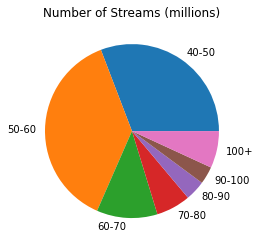

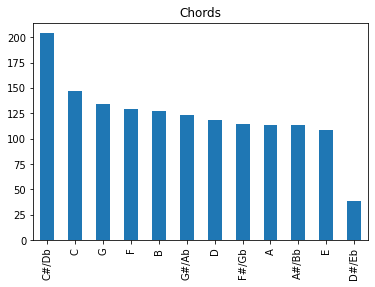

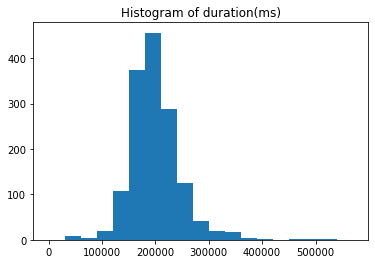

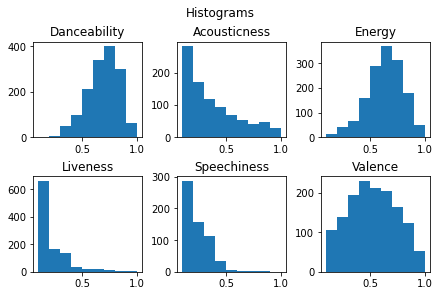

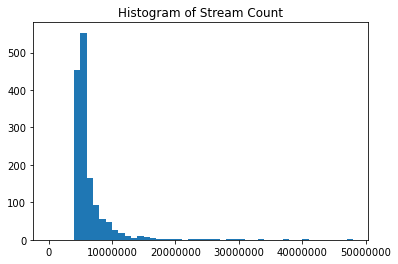

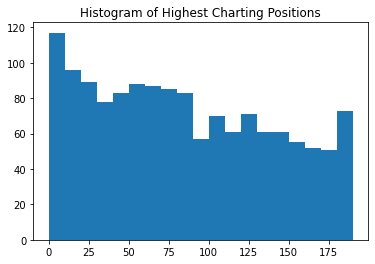

In [53]:
stream_bins = list(range(0, 10000001, 1000000)) + [99999999]
# streams = [int(stream.replace(',', '')) for stream in data['Streams'].tolist()]
hist, bin_edges = np.histogram(data['Streams'], bins=stream_bins)
percentages = hist/np.sum(hist)
labels = np.array(['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '100+'])
labels = labels[percentages != 0]
percentages = percentages[percentages != 0]
fig, ax = plt.subplots(1, 1)
ax.pie(percentages, labels=labels)
ax.set_title('Number of Streams (millions)')
plt.show()

# should sort chords from low to high?
ax = data['Chord'].value_counts().plot.bar()
ax.set_title('Chords')
plt.show()

duration_bins = list(range(0, 30000*2*10, 30000))
fig, ax = plt.subplots(1, 1)
ax.hist(pd.to_numeric(data["Duration (ms)"]), bins=duration_bins)
ax.ticklabel_format(style='plain')
ax.set_title('Histogram of duration(ms)')
plt.show()

zero_to_one_bins = np.linspace(0.1, 1.0, 10)
fig, ax = plt.subplots(2, 3, constrained_layout=True)
zero_to_one_columns = ['Danceability', 'Acousticness', 'Energy', 'Liveness', 'Speechiness', 'Valence']
for i in range(len(zero_to_one_columns)):
    idx = np.unravel_index(i, (2, 3))
    ax[idx].hist(pd.to_numeric(data[zero_to_one_columns[i]]), bins=zero_to_one_bins)
    ax[idx].set_title(zero_to_one_columns[i])
fig.suptitle('Histograms')
plt.show()

duration_bins = list(range(0, max(data['Streams']), 1000000))
fig, ax = plt.subplots(1, 1)
ax.hist(pd.to_numeric(data["Streams"]), bins=duration_bins)
ax.ticklabel_format(style='plain')
ax.set_title('Histogram of Stream Count')
plt.show()

duration_bins = list(range(0, max(data['Highest Charting Position']), 10))
fig, ax = plt.subplots(1, 1)
ax.hist(pd.to_numeric(data['Highest Charting Position']), bins=duration_bins)
ax.ticklabel_format(style='plain')
ax.set_title('Histogram of Highest Charting Positions')
plt.show()

After feature visualization, we explored the number of songs that charted a particular number of times along with a distribution of the highest charting positions. We also used a heatmap to visualize the correlation between the features. Very few features were highly correlated (besides energy and loudness) so we decided not to remove any of the features at this step due to redundancy.

In [54]:
# Exploring 
data.groupby('Number of Times Charted').describe()['Highest Charting Position']

,count,mean,std,min,25%,50%,75%,max
Number of Times Charted,,,,,,,,
1,491.0,128.949084,47.672859,5.0,87.00,134.0,171.0,200.0
2,146.0,81.767123,50.590178,10.0,43.00,66.5,111.5,194.0
3,106.0,82.754717,55.189166,2.0,34.00,71.0,128.0,193.0
4,67.0,86.119403,53.110098,10.0,49.00,71.0,132.0,194.0
5,66.0,79.333333,51.563354,3.0,38.25,69.5,120.0,189.0
...,...,...,...,...,...,...,...,...
81,2.0,61.000000,28.284271,41.0,51.00,61.0,71.0,81.0
82,2.0,57.000000,52.325902,20.0,38.50,57.0,75.5,94.0
83,15.0,27.133333,31.854281,1.0,4.00,13.0,38.5,99.0


<AxesSubplot:>

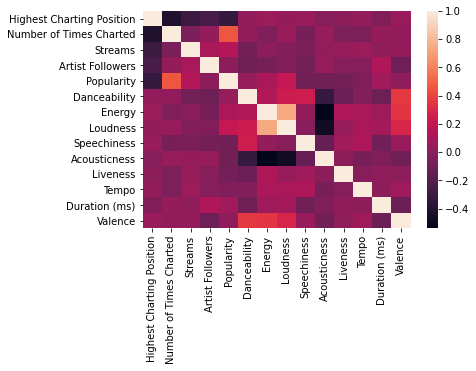

In [55]:
# Exploring
numeric_data = data.drop(["Artist_Class", "Chord_Class", "Genre_Class"], axis=1)
sns.heatmap(numeric_data.corr(method='pearson'))

# Feature Engineering

Next, we engineered some features to make the classification process easier. We dropped some categorical features that we had numerical equivalents for, considered only the first artist for each song as opposed to all of them, and rounded the number of streams to the nearest million and artist followers to the nearest hundred thousand to make predictions smoother.

In [56]:
# Clean data a bit more
# drop non-number data (including data we've converted to numbers)
cols_to_drop = ['Week of Highest Charting', 'Artist', 'Genre', 'Release Date', 'Weeks Charted', 'Chord']
data_only_nums = data.drop(cols_to_drop, axis=1)

# only consider first artist for ease, round streams
data_only_nums['Artist_Class'] = data_only_nums.apply(lambda x: x[0], axis=1)

# round streams so we have a chance at predicting it well
data_only_nums['Streams'] = (data_only_nums['Streams'] / 10000000).astype(int) * 10000000
data_only_nums['Artist Followers'] = (data_only_nums['Artist Followers'] / 100000).astype(int) * 100000
data_only_nums.head()

,Highest Charting Position,Number of Times Charted,Streams,Artist_Class,Artist Followers,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord_Class,Genre_Class
0,1,8,40000000,1,3300000,100.0,0.714,0.800,-4.808,0.0504,0.1270,0.3590,134.002,211560,0.589,9,6
1,2,3,40000000,2,2200000,99.0,0.591,0.764,-5.484,0.0483,0.0383,0.1030,169.928,141806,0.478,10,3
2,1,11,40000000,1,6200000,99.0,0.563,0.664,-5.044,0.1540,0.3350,0.0849,166.928,178147,0.688,3,6
3,3,5,30000000,3,83200000,98.0,0.808,0.897,-3.712,0.0348,0.0469,0.3640,126.026,231041,0.591,9,6
4,5,1,30000000,5,5400000,96.0,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,5,6


Finally, we binned the highest charting positions into 20 bins and determined the final shape of our dataset after feature engineering and cleaning. We retained 16 features (21 originally) and 1470 records (1556 originally).

In [57]:
# Create data/labels frames
genre_labels = data_only_nums['Genre_Class'].values.ravel()
genre_data = data_only_nums.drop(['Genre_Class'], axis=1)

charting_labels = data_only_nums['Highest Charting Position'].values
charting_data = data_only_nums.drop(['Highest Charting Position'], axis=1)

# Bin the highest charting positions
discretize = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='uniform')
charting_labels = np.array(charting_labels).reshape(-1, 1)
discretize.fit(charting_labels)
charting_labels = pd.Series(discretize.transform(charting_labels).flatten())


print('Genre Data Shape:', genre_data.shape, '\nGenre Labels Shape:', len(genre_labels))
print('Charting Data Shape:', charting_data.shape, '\nCharting Labels Shape:', len(charting_labels))

Genre Data Shape: (1470, 16) 
Genre Labels Shape: 1470
Charting Data Shape: (1470, 16) 
Charting Labels Shape: 1470


## Class Imbalances 
From our visualization of the song genres, it is apparent that there are many more pop and rap records represented in the Spotify dataset than the other song genres. To address this class imbalance, we will use the TomkLinks method implemented by the *imblearn* package which undersamples the majority classes to balance the dataset. It is notable that *imblearn*'s pipeline automatically does not apply the TomkLinks to the test set.

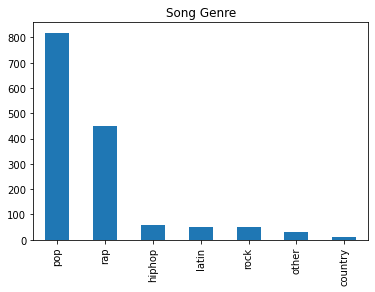

In [58]:
# should sort chords from low to high?
ax = data['Genre_Class'].value_counts().plot.bar()
ax.set_title('Song Genre')
genre_names = [name for name, _ in genre_freq.most_common(len(popular))]
ax.set_xticklabels(labels=genre_names)
plt.show()

# Data Analysis

For our data analysis, we will train four classifiers on both predicing song genre and highest charting position. The four classifier will be use are:

1. Decision Tree
2. K-Nearest Neighbors
3. Adaboost
4. Neural Network

Because of the class imbalance in our dataset for song genres, we will use weighted F-Score rather than accuracy as our metric. Unlike the normal F1 score, the weighted F1 score calculates an average F1 score weighted by the support of each label to help account for label imbalance. 

## Decision Tree

In [59]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.pipeline import make_pipeline as make_pipeline_with_sampler
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import GridSearchCV

def do_decision_tree(data, labels, label_name):
    # fit a decision tree classifier across 5 cross folds
    clf = DecisionTreeClassifier(criterion='entropy')
    
    pipe = make_pipeline_with_sampler(        
                                    TomekLinks(),
                                    clf
            )

    # Create grid search
    param_grid = {
        'decisiontreeclassifier__criterion': ["gini", "entropy"],
        'decisiontreeclassifier__max_depth': list(range(1, 10, 2))
    }
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_weighted')

    # Perform Cross Validation
    scores = cross_val_score(grid_search, data, labels, cv=5)
    print('F1 Weighted Score:', scores.mean())
    
print("Genre Classification")
do_decision_tree(genre_data, genre_labels, 'Genre')
print("Charting Position Classification")
do_decision_tree(charting_data, charting_labels, 'Highest Charting Position')

Genre Classification
F1 Weighted Score: 0.6189633099690252
Charting Position Classification
F1 Weighted Score: 0.9897422186707334


### Results
A decision tree working this well with our data is surprising, especially with how well it can predict charting position. This is likely due to the fact that there are a lot of numerical features such as danceability and energy. This allows the tree to split on these features and make more accurate predictions.

## KNN

In [60]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer

def do_knn(data, labels, label_name):

    numeric_feat = ["Danceability", "Energy", "Loudness", "Speechiness", "Acousticness", "Liveness", "Tempo", 
                    "Duration (ms)", "Valence", "Artist Followers", "Popularity", "Number of Times Charted", "Streams"]

    cat_feat = ["Artist_Class", "Chord_Class"]


    # Add chart pos as feat for genre classifier
    if label_name == "Genre":
        numeric_feat.append("Highest Charting Position")
    # Add genre as feat for char pos classifier
    else:
        cat_feat.append("Genre_Class")

    # Don't process features that we dropped for testing
    numeric_feat = [feat for feat in numeric_feat if feat in data.columns]
    cat_feat = [feat for feat in cat_feat if feat in data.columns]

    # Sampler
    sampler = TomekLinks()

    # One-hot encode categorical features
    encoder = OneHotEncoder(handle_unknown='ignore')

    # Standardize numeric features
    scalar = StandardScaler()

    # PCA
    pca = PCA()

    # Create feature transformation pipeline
    numeric_transform = make_pipeline_with_sampler(scalar, pca)
    cat_transform = make_pipeline_with_sampler(encoder)

    feat_transform = ColumnTransformer(
                            transformers=[ ('num_transform', numeric_transform, numeric_feat),
                                        ('cat_transform', cat_transform, cat_feat)]
    )

    # KNN 
    knn = KNeighborsClassifier(n_neighbors=7)

    # Pipeline 
    pipe = make_pipeline_with_sampler(
                                    sampler,
                                    feat_transform,
                                    knn
            )

    # Create grid search
    param_grid = {
        'kneighborsclassifier__n_neighbors': list(range(1, 10, 2))
    }
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_weighted')

    # Perform Cross Validation
    scores = cross_val_score(grid_search, data, labels, cv=5)
    print('F1 Weighted Score:', scores.mean())

print("Genre Classification")
do_knn(genre_data, genre_labels, "Genre")
print("Charting Position Classification")
do_knn(charting_data, charting_labels, "Highest Charting Position")

Genre Classification
F1 Weighted Score: 0.547179916760073
Charting Position Classification
F1 Weighted Score: 0.10075136437843395


### Results
While KNN performed similarly to the decision tree for predicting genre, KNN did much worse with predicting highest charting position. In order to try and improve this classification, we will reduce the dimensionality of our data by pruning extraneous features and only including columns like "danceability", "tempo", etc which are directly related to the muscality of the song.

In [61]:
genre_drop_cols = ['Highest Charting Position', 'Number of Times Charted', 'Streams', 'Artist_Class', 'Artist Followers', 'Popularity']
charting_drop_cols = ['Genre_Class', 'Number of Times Charted', 'Streams', 'Artist_Class', 'Artist Followers', 'Popularity']
new_genre_data = genre_data.drop(genre_drop_cols, axis=1)
new_charting_data = charting_data.drop(charting_drop_cols, axis=1)
print("Genre Classification")
do_knn(new_genre_data, genre_labels, 'New Genre')
print("Charting Position Classification")
do_knn(new_charting_data, charting_labels, 'New Highest Charting Position')

Genre Classification
F1 Weighted Score: 0.5472643610897856
Charting Position Classification
F1 Weighted Score: 0.04586972373185


This general dimensionality reduction actually reduced the weighted F1 score of KNN in predicting highest charting position. This may be reconciled based on the information we lost during reduction. It is possible that artists with more followers will probably tend to have higher charting positions with their song than someone else who may happen to have a similar "danceability" rating. Because of this, features like artist followers that are not directly related to the song may allow for better prediction of charting position than features more correlated with the song like dancability and tempo since these are more generalized across the music industry.

## Ensemble (Adaboost)

In [62]:
from sklearn.ensemble import AdaBoostClassifier

def do_adaboost(data, labels, label_name):
    data = data.values
    tree = DecisionTreeClassifier(criterion='entropy')
    clf = AdaBoostClassifier(base_estimator=tree)


    pipe = make_pipeline_with_sampler(
        TomekLinks(),
        clf
    )

    # Create grid search
    param_grid = {
        'adaboostclassifier__n_estimators': list(range(50, 300, 50)),
        'adaboostclassifier__learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 1.0]
    }

    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_weighted', n_jobs=10)
    
    scores = cross_val_score(grid_search, data, labels, cv=5)
    print('F1 Weighted Score:', scores.mean())

print("Genre Classification")
do_adaboost(genre_data, genre_labels, 'Genre')
print("Charting Position Classification")
do_adaboost(charting_data, charting_labels, 'Highest Charting Position')


Genre Classification
F1 Weighted Score: 0.6290589770236643
Charting Position Classification
F1 Weighted Score: 0.9897422186707334


### Results
The ensemble method of classification does a similar job at classifying genre as decision trees and KNN. However, it is very accurate in terms of predicting highest charting position. This is likely because AdaBoost is boosting the more difficult to classify records and giving them a higher weight in the next model instance. 

## Neural Network

In [69]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import sys
import os

# Suppress convergence warnings
from warnings import simplefilter
if not sys.warnoptions:
    simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"


def do_mlp(data, labels, label_name):
    numeric_feat = ["Danceability", "Energy", "Loudness", "Speechiness", "Acousticness", "Liveness", "Tempo", 
                "Duration (ms)", "Valence", "Artist Followers", "Popularity", "Number of Times Charted", "Streams"]

    cat_feat = ["Artist_Class", "Chord_Class"]

    # Add chart pos as feat for genre classifier
    if label_name == "Genre":
        numeric_feat.append("Highest Charting Position")
    # Add genre as feat for char pos classifier
    else:
        cat_feat.append("Genre_Class")

    # Don't process features that we dropped for testing
    numeric_feat = [feat for feat in numeric_feat if feat in data.columns]
    cat_feat = [feat for feat in cat_feat if feat in data.columns]

    # Sampler
    sampler = TomekLinks()

    # One-hot encode categorical features
    encoder = OneHotEncoder(handle_unknown='ignore')

    # Standardize numeric features
    scalar = StandardScaler()

    # PCA
    pca = PCA()

    # Create feature transformation pipeline
    numeric_transform = make_pipeline_with_sampler(scalar, pca)
    cat_transform = make_pipeline_with_sampler(encoder)

    feat_transform = ColumnTransformer(
                            transformers=[ ('num_transform', numeric_transform, numeric_feat),
                                        ('cat_transform', cat_transform, cat_feat)]
    )

    # MLP
    mlp = MLPClassifier(learning_rate="adaptive")

    pipe = make_pipeline_with_sampler(
        sampler,
        feat_transform,
        mlp
    )

    # Create grid search
    param_grid = {
        'mlpclassifier__hidden_layer_sizes': list(zip(range(100, 501, 100))),
        'mlpclassifier__activation': ['relu', 'logistic'],
        'mlpclassifier__learning_rate_init':[0.001, 0.0001],
    }

    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_weighted', n_jobs=10)

    scores = cross_val_score(grid_search, data, labels, cv=5)
    print('F1 Weighted Score:', scores.mean())

do_mlp(genre_data, genre_labels, "Genre")
do_mlp(charting_data, charting_labels, "Highest Charting Position")

F1 Weighted Score: 0.558337671630548
F1 Weighted Score: 0.8864296929486253


### Results
The prediction of genre has a slightly lower F-score than decision tree and ensembling, but is still comparable to them and KNN. The F-score for predicting highest charting position is fairly high likely because the neural network is able to modulate a large number of hyperparameters/weights to better fit the data.

# Training the Final Decision Tree Model
Because the Adaboost and decision tree classifiers performed the best out of all the models we tried in terms of weighted F-score on both the highest charting position and song genre classfication, we found the optimal hyperparameters for both models using a grid search on the whole dataset for both classification tasks. For the Adaboost classifier, we also tuned the base classifier's hyperparameters which we did not do during cross validation due to the heavy computational cost.

In [71]:
def final_decisiontree(data, labels, label_name):
    # fit a decision tree classifier across 5 cross folds
    clf = DecisionTreeClassifier(criterion='entropy')
    
    pipe = make_pipeline_with_sampler(        
                                    TomekLinks(),
                                    clf
            )

    # Create grid search
    param_grid = {
        'decisiontreeclassifier__criterion': ["gini", "entropy"],
        'decisiontreeclassifier__max_depth': list(range(1, 30, 2))
    }    

    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_weighted', n_jobs=10)
    grid_search.fit(data, labels)

    print("Best Hyperparameters for", label_name, ":", grid_search.best_params_)
    print("F1 Weighted Score for", label_name, ":", grid_search.best_score_)

def final_adaboost(data, labels, label_name):
    data = data.values
    
    tree = DecisionTreeClassifier(criterion='entropy')

    clf = AdaBoostClassifier(base_estimator=tree)

    pipe = make_pipeline_with_sampler(
        TomekLinks(),
        clf
    )

    # Create grid search
    param_grid = {
        'adaboostclassifier__n_estimators': list(range(50, 300, 50)),
        'adaboostclassifier__learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 1.0],
        'adaboostclassifier__base_estimator__criterion': ["gini", "entropy"],
        'adaboostclassifier__base_estimator__max_depth': list(range(1, 30, 2))
    }

    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_weighted', n_jobs=14)
    grid_search.fit(data, labels)

    print("Best Hyperparameters for", label_name, ":", grid_search.best_params_)
    print("F1 Weighted Score for", label_name, ":", grid_search.best_score_)
    

print("Decision Tree")
final_decisiontree(genre_data, genre_labels, "Genre")
print()
final_decisiontree(charting_data, charting_labels, "Highest Charting Position")
print()
print("Adaboost")
final_adaboost(genre_data, genre_labels, "Genre")
print()
final_adaboost(charting_data, charting_labels, "Highest Charting Position")

Decision Tree
Best Hyperparameters for Genre : {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 9}
F1 Weighted Score for Genre : 0.639919345613042

Best Hyperparameters for Highest Charting Position : {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 15}
F1 Weighted Score for Highest Charting Position : 0.9897422186707334

Adaboost
Best Hyperparameters for Genre : {'adaboostclassifier__base_estimator__criterion': 'entropy', 'adaboostclassifier__base_estimator__max_depth': 11, 'adaboostclassifier__learning_rate': 0.1, 'adaboostclassifier__n_estimators': 100}
F1 Weighted Score for Genre : 0.6965662660143849

Best Hyperparameters for Highest Charting Position : {'adaboostclassifier__base_estimator__criterion': 'gini', 'adaboostclassifier__base_estimator__max_depth': 3, 'adaboostclassifier__learning_rate': 0.001, 'adaboostclassifier__n_estimators': 200}
F1 Weighted Score for Highest Charting Position : 0.9897422186707334

## Overall Conclusions
In order to predict genre and highest charting position, we used four classifiers: decision tree, KNN, an ensemble method with boosting, and neural networks. Prior to classification, in data preparation, we removed extraneous features such as song ID and mapped categorical features to unique integer identifiers. Then, in data exploration, we visualized the range of each feature to easily remove any noise in the data or outliers for a particular feature. For feature engineering, we modulated some features for easier classification such as only considering the first artist on the song and rounding streams for better predictions. We also did one hot encoding for some of the categorical features. In the data exploration phase, we found that a majority of the records were from the pop and rap genres resulting in a class imbalance. In order to compensate for this, we used TomkLinks which undersamples the majority class to offset the imbalance. Rather than accuracy, we decided to use weighted F1 score which is more robust to class imbalance. Then, the data was ready for classification. For genre, the weighted F1 score of predictions were around 0.62 (decision tree), 0.55 (KNN), 0.63 (Adaboost), and 0.56 (neural net). These scores are all pretty similar with ensembling doing the best. For highest charting position, the prediction weighted F1 scores were 0.99 (decision tree), 0.10 (KNN), 0.99 (Adaboost), and 0.89 (neural net). We attempted to improve the weighted F1 score of the KNN classifier through dimensionality reduction, but this actually diminished the weighted F1 score. This is likely due to the fact that when dimensionality is reduced, information is lost from the dataset that may be useful to the classfier. 

Because the decision tree and adaboost models had the best F1 scores during cross-validation, we trained a decision tree model and an Adaboost model on the full dataset. For the Adaboost model, we also performed a grid search on the base decision tree classifier's hyperparameters. For genre classification, the weighted F1 scores were 0.64 (decision tree) and 0.70 (Adaboost). For highest charting position, the weighted F1 sores were 0.99 (decision tree) and 0.99 (Adaboost).

Overall, the Adaboost classifier and decision tree classifiers performed the best at predicting the genre and highest charting position of the songs in this Spotify dataset with the Adaboost classifier performing slightly better on genre classification during cross-validation. Since the decision tree trains much faster than the Adaboost classifier, we would recommend using decision trees for charting position classification. For genre classification, Adaboost gives slightly better performance. However, if training speed is a significant factor, a decision tree can be used for a small reduction in performance. 